In [1]:
import xarray as xr
from sea_breeze import utils, load_model_data
import numpy as np
import scipy
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
#Load in BARRA-R fixed data

lat_slice, lon_slice = utils.get_aus_bounds()

m="barra_r"
angle_ds = load_model_data.get_coastline_angle_kernel(
    compute=False,
    path_to_load="/g/data/ng72/ab4502/coastline_data/"+m+".nc",
    lat_slice=lat_slice,
    lon_slice=lon_slice
)
orog,lsm = load_model_data.load_barra_static("AUS-11",lon_slice,lat_slice)

In [3]:
#Load in the hourly F dataset
ds = xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/"+\
                  "barra_r"+\
                  "/filters/filtered_mask_no_hourly_change_"+\
                  "F"+\
                  "_*.zarr/",
             chunks={}, engine="zarr")


#lst_offset = np.round(np.mean(lsm.lon.values) / 180 * 12)
#ds["time"] = pd.to_datetime(ds.time) + dt.timedelta(hours=lst_offset)

#Resample to daily at each grid point
ds = ds.groupby(ds.time.dt.date).max().persist()

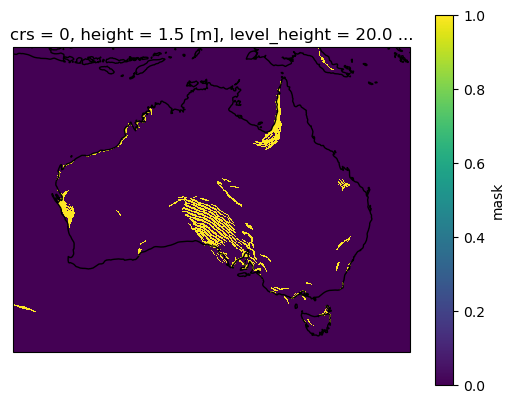

In [4]:
ax = plt.axes(projection=ccrs.PlateCarree())
ds.mask.isel(date=3).plot()
ax.coastlines()

In [5]:
def create_elliptical_footprint(radius_y, radius_x):
    """Create an elliptical footprint with given radii for y and x directions."""
    y, x = np.ogrid[-radius_y:radius_y+1, -radius_x:radius_x+1]
    footprint = (x**2 / radius_x**2) + (y**2 / radius_y**2) <= 1
    return footprint   

#Return the size of each pixel
dx,dy,pixel_area = utils.metpy_grid_area(ds.lon,ds.lat)

#Create a footprint of 50 km 
R_km=52
radius_y = int(np.round(R_km / np.mean(dy.data)))
radius_x = int(np.round(R_km / np.mean(dx.data)))
footprint = create_elliptical_footprint(radius_y,radius_x)    

#scipy.ndimage.maximum_filter(ds.mask.isel(time=slice(0,10)),footprint=footprint)

import tqdm

#For each day, take the rolling maximum over a 50 km radius, and mask out points that are further from 50 km from the coast
temp_filtered_coastal_ls = []
for i in tqdm.tqdm(np.arange(ds.date.shape[0])):

    temp = ds.isel(date=i)
    
    temp_filtered = xr.DataArray(
            scipy.ndimage.maximum_filter(temp.mask,footprint=footprint),
            coords=temp.coords, dims=temp.dims)
    temp_filtered_coastal = xr.where(
        angle_ds.min_coast_dist <= 50,
        temp_filtered,
        0)
    temp_filtered_coastal_ls.append(temp_filtered_coastal)

# plt.figure(figsize=[12,5])
# ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
# xr.where(angle_ds.sel(lon=slice(108,158.5)).min_coast_dist<=20,
# xr.DataArray(
#         scipy.ndimage.maximum_filter(temp.mask,footprint=footprint),
#         coords=temp.coords, dims=temp.dims),
#          0).plot()
# ax.coastlines(lw=0.5)


# ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
# temp.mask.plot()
# ax.coastlines(lw=0.5)

100%|██████████| 178/178 [00:03<00:00, 44.98it/s]


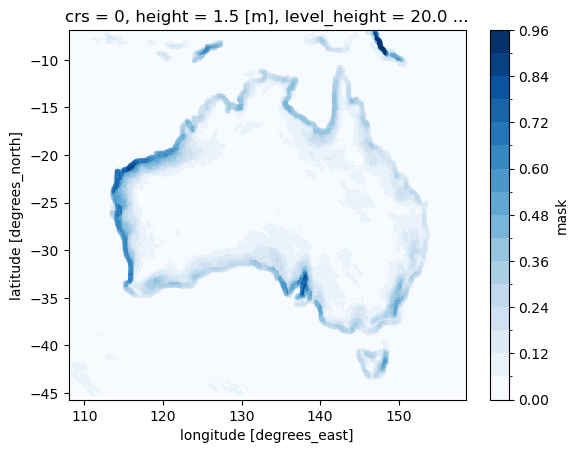

In [25]:
rolling_max = ds.mask.rolling({"lat":4,"lon":4}).max().mean("date").persist()
rolling_max.plot(cmap="Blues",levels=20)

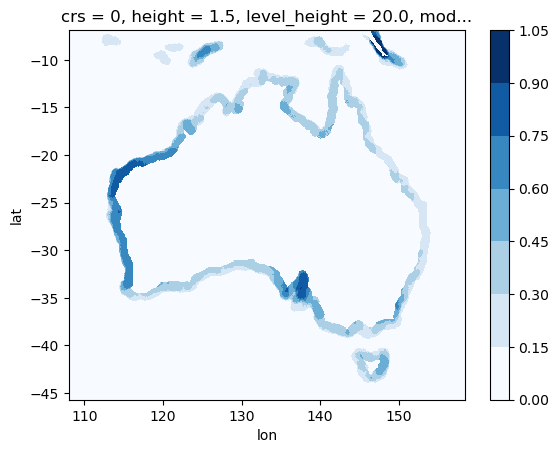

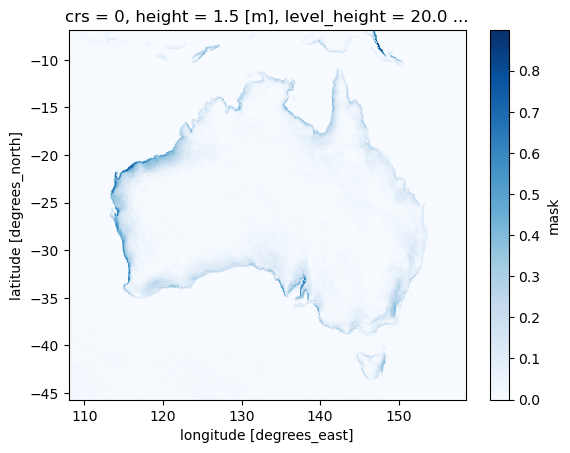

In [6]:
plt.figure()
xr.concat(temp_filtered_coastal_ls,dim="date").mean("date").plot(cmap="Blues",levels=10)

plt.figure()
ds.mask.mean("date").plot(cmap="Blues")

In [24]:
brisbane_lat, brisbane_lon = -27.5716, 153.0071   #0.30 sb/day (Soderholm)
adelaide_lat, adelaide_lon = -34.9524, 138.5196   #0.42 sb/day (Masouleh)
perth_lat, perth_lon = -31.9275, 115.9764         #0.66 sb/day (Rafiq, based on Masselink)

print(rolling_max.sel(lat=brisbane_lat,lon=brisbane_lon,method="nearest").values)
print(rolling_max.sel(lat=adelaide_lat,lon=adelaide_lon,method="nearest").values)
print(rolling_max.sel(lat=perth_lat,lon=perth_lon,method="nearest").values)

0.1348314606741573
0.4438202247191011
0.601123595505618


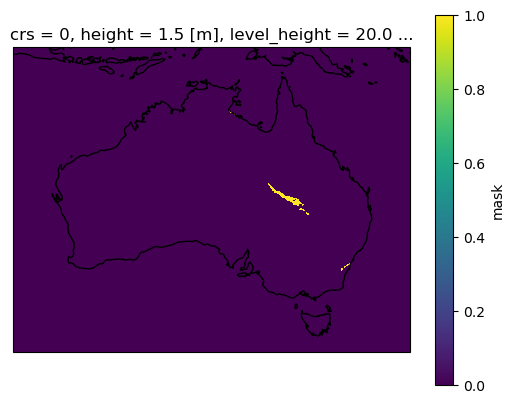

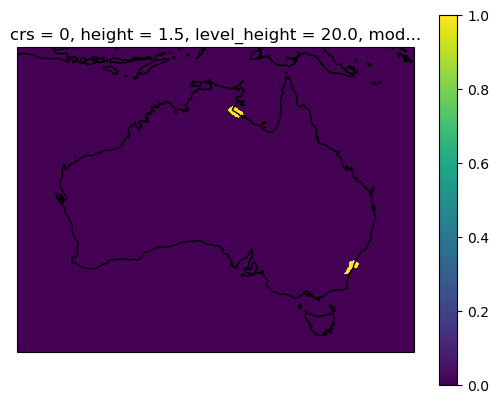

In [98]:
ax = plt.axes(projection=ccrs.PlateCarree())
temp.mask.plot()
ax.coastlines()

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
temp_filtered_coastal.plot()
ax.coastlines()

In [99]:
lat = ds.lat.values
lon = ds.lon.values
xx,yy = np.meshgrid(lon,lat)

coast_x, coast_y = np.where(angle_ds.coast==1)
coast_lon = lon[coast_y]
coast_lat = lat[coast_x]
coast_X = np.array([coast_lat, coast_lon]).T
coast_kdt = scipy.spatial.KDTree(coast_X)

In [100]:
_,coast_ind = coast_kdt.query(np.array([yy.flatten(),xx.flatten()]).T, 1)
target_lon_coast = coast_lon[coast_ind.reshape((lat.shape[0],lon.shape[0]))]
target_lat_coast = coast_lat[coast_ind.reshape((lat.shape[0],lon.shape[0]))]
target_lon_coast = xr.DataArray(target_lon_coast,dims=("lat","lon"),coords={"lat":lsm.lat,"lon":lsm.lon})
target_lat_coast = xr.DataArray(target_lat_coast,dims=("lat","lon"),coords={"lat":lsm.lat,"lon":lsm.lon})

In [105]:
def index_ts_dataarray(ts, target_lat, target_lon):
    """
    Index the ts DataArray using the target latitudes and longitudes.
    
    Parameters:
    * ts: xarray DataArray of the time series data
    * target_lat: 2D array of target latitudes
    * target_lon: 2D array of target longitudes
    """
    # Convert target lat/lon to indices
    lat_idx = xr.DataArray(np.searchsorted(ts.lat, target_lat))
    lon_idx = xr.DataArray(np.searchsorted(ts.lon, target_lon))

    # Use advanced indexing to get the values
    indexed_ts = ts.isel(lat=lat_idx, lon=lon_idx).values
    
    return indexed_ts

F_filtered_coastal = xr.concat(temp_filtered_coastal_ls,dim="date")
coast_selected_ls = []

for i in tqdm.tqdm(np.arange(ds.date.shape[0])):
    coast_selected = xr.DataArray(
        index_ts_dataarray(
            F_filtered_coastal.isel(date=i),target_lat_coast,target_lon_coast),
        dims=F_filtered_coastal.isel(date=i).dims,coords=F_filtered_coastal.isel(date=i).coords)
    coast_selected_ls.append(coast_selected)

100%|██████████| 181/181 [00:01<00:00, 111.70it/s]


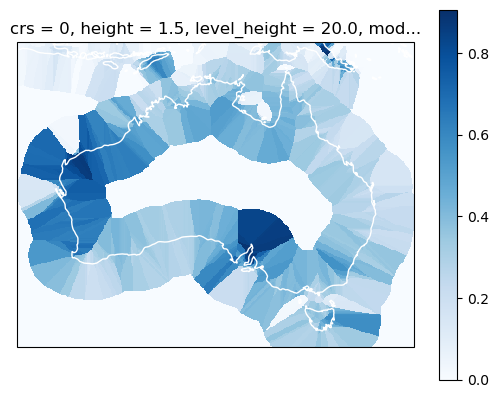

In [110]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
xr.where(
    angle_ds.min_coast_dist<=500,
    xr.concat(coast_selected_ls,dim="date").mean("date"),
    0).plot(cmap="Blues")
ax.coastlines(color="w")




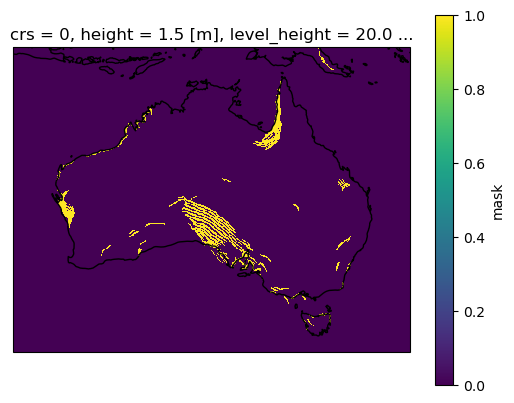

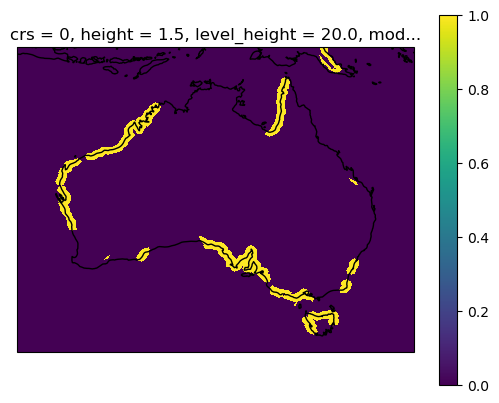

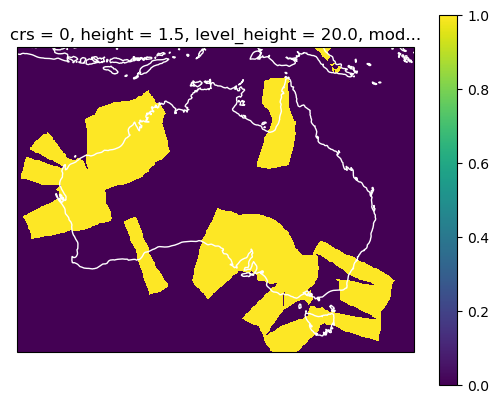

In [87]:
ax = plt.axes(projection=ccrs.PlateCarree())
temp.mask.plot()
ax.coastlines()

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
temp_filtered_coastal.plot()
ax.coastlines()

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
xr.where(
    angle_ds.min_coast_dist<=500,
    coast_selected,
    0).plot()
ax.coastlines(color="w")

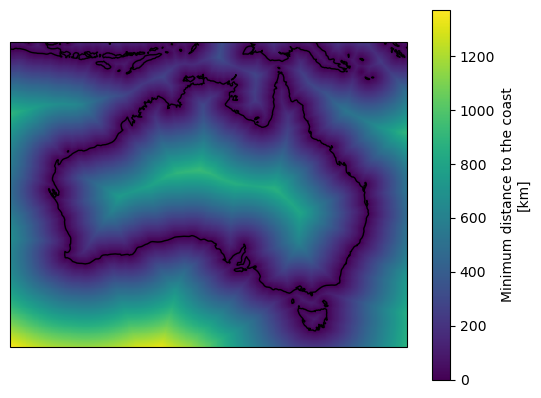

In [65]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
angle_ds.min_coast_dist.plot()
ax.coastlines()